# Gaps on structure functions: demo of pipeline

- Inspired by existing code
- Test on one PSP to start, then two PSP and one Wind for training and testing
- Check against target dataframes as you go

### 0. Import dependencies

In [38]:
import pickle
import pandas as pd
import numpy as np
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates

In [15]:
# For current Wind importing

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

### 1. Download files

Run in terminal

In [16]:
# For selecting a range of dates

# wget --no-clobber --directory-prefix=data/raw/psp  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_20181102{00..12}_v02.cdf
# wget --no-clobber --directory-prefix=data/raw/wind/ https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2016/wi_h2_mfi_201601{01..07}_v05.cdf

# For entire folders

# wget --no-clobber --directory-prefix=data/raw/psp --recursive -np -nv -nH --cut-dirs=7 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
# wget --no-clobber --directory-prefix=data/raw/wind --recursive -np -nv -nH --cut-dirs=2 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/

### 2. Read in data and split into standardised intervals

#### PSP data

In [16]:
raw_file_list = sorted(glob.iglob("data/raw/psp/" + "/*.cdf"))
print(raw_file_list)

['data/raw/psp\\psp_fld_l2_mag_rtn_2018110200_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110206_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110212_v02.cdf']


In [17]:
psp_data = dif.read_cdfs(
    [raw_file_list[0]],  # LIMIT HERE!
    {"epoch_mag_RTN": (0), "psp_fld_l2_mag_RTN": (0, 3), "label_RTN": (0, 3)},
)
psp_data_ready = dif.extract_components(
    psp_data,
    var_name="psp_fld_l2_mag_RTN",
    label_name="label_RTN",
    time_var="epoch_mag_RTN",
    dim=3,
)
psp_df = pd.DataFrame(psp_data_ready)
psp_df["Time"] = pd.to_datetime("2000-01-01 12:00") + pd.to_timedelta(
    psp_df["epoch_mag_RTN"], unit="ns"
)
psp_df = psp_df.drop(columns="epoch_mag_RTN").set_index("Time")

df_raw = psp_df["B_R"]

print(df_raw.info())
print(df_raw.head())

reading file  data/raw/psp\psp_fld_l2_mag_rtn_2018110200_v02.cdf
Done reading data
<class 'pandas.core.series.Series'>
DatetimeIndex: 1582027 entries, 2018-11-02 00:01:09.195182976 to 2018-11-02 06:01:09.171900544
Series name: B_R
Non-Null Count    Dtype  
--------------    -----  
1582027 non-null  float64
dtypes: float64(1)
memory usage: 24.1 MB
None
Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64


#### Wind data
Takes a while due to large files

In [50]:
# raw_file_list = sorted(glob.iglob("data/raw/wind/" + "/*.cdf"))
# print(raw_file_list)

['data/raw/wind\\wi_h2_mfi_20160101_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160102_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160103_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160104_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160105_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160106_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160107_v05.cdf']


In [53]:
# df = utils.pipeline(
#     raw_file_list[0],
#     varlist=sys_arg_dict["mag_vars"],
#     thresholds=sys_arg_dict["mag_thresh"],
#     cadence=sys_arg_dict["dt_hr"],
# )

# print("Reading {0}: {1:.2f}% missing".format(raw_file_list[0], df.iloc[:,0].isna().sum()/len(df)*100))

# # Ensuring observations are in chronological order
# df_wind_hr = df.sort_index()

# # df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
# df_wind_hr = df_wind_hr.rename(
#     columns={
#         params.Bwind: "Bwind",
#         params.Bx: "Bx",
#         params.By: "By",
#         params.Bz: "Bz",
#     }
# )

# missing = df_wind_hr.iloc[:, 0].isna().sum() / len(df_wind_hr)

# if missing > 0.4:
#     # Replacing values in lists with na
#     print("Large missing %")
# else:
#     int_wind_hr = df_wind_hr.interpolate().ffill().bfill()

# df_raw = int_wind_hr["Bx"]

# print(df_raw.info())
# print(df_raw.head())

Reading data/raw/wind\wi_h2_mfi_20160101_v05.cdf: 3.02% missing
<class 'pandas.core.series.Series'>
DatetimeIndex: 939130 entries, 2016-01-01 00:00:00 to 2016-01-01 23:59:59.868000
Freq: 92L
Series name: Bx
Non-Null Count   Dtype  
--------------   -----  
939130 non-null  float32
dtypes: float32(1)
memory usage: 10.7 MB
None
Timestamp
2016-01-01 00:00:00.000    5.879855
2016-01-01 00:00:00.092    5.890072
2016-01-01 00:00:00.184    5.862018
2016-01-01 00:00:00.276    5.875757
2016-01-01 00:00:00.368    5.886422
Freq: 92L, Name: Bx, dtype: float32


In [7]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}\n".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 1582027
Duration of interval: 0 days 05:59:59.976717568
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = -28.383399058746512
Standard deviation = 18.777635215345533



In [22]:
tc_approx = 500  # s: 500 for PSP, 2000 for Wind
cadence_approx = 0.1  # s: 0.1 for PSP, 1 for Wind

tc_n = 10  # Number of actual (computed) correlation times we want in our standardised interval...
interval_length = 10000  # ...across this many points

df = df_raw.resample(str(cadence_approx) + "S").mean()

good_inputs_list = []
tc_list = []
cadence_list = []

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df],
    nlags=10000,
    plot=False,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

if tc == -1:
    tc = tc_approx
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc not found for this interval, setting to 500s (default) -> cadence = {new_cadence}s"
    )

else:
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tc across {interval_length} points)"
    )

tc_list.append(tc)
cadence_list.append(new_cadence)

try:
    interval_approx_resampled = df.resample(
        str(np.round(new_cadence, 3)) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        # Check if interval is complete
        if interval.isnull().sum() > 0:
            print("interval contains missing data even after down-sampling; skipping")
            # Note: due to merging cannot identify specific file with missing data here
            # only file list as here:
            # print("corresponding input file list: ", file_list_split[core])
        else:
            # print("Interval successfully processed")
            int_norm = utils.normalize(interval)
            good_inputs_list.append(int_norm)

except Exception as e:
    print(f"An error occurred: {e}")

if len(good_inputs_list) == 0:
    print("No good inputs found (good_inputs_list is empty). Exiting.")
    exit(1)

# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(good_inputs_list[0]))
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 0.25 * len(good_inputs_list[0]))
powers = [0.5, 2]

print(
    "\nNumber of standardised intervals: ",
    len(good_inputs_list),
    "about to be gapped",
    times_to_gap,
    "times",
)

tc calculated to be 736.2s -> cadence = 0.74s (for 10tc across 10000 points)

Number of standardised intervals:  2 about to be gapped 5 times


Text(0, 0.5, '$B_R$ (nT)')

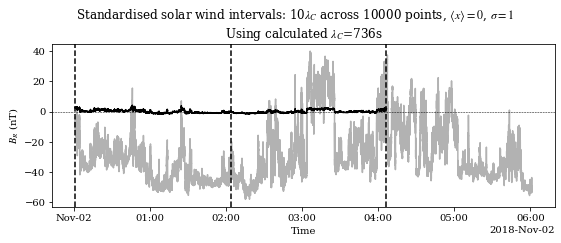

In [19]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(df, alpha=0.3, c="black")
plt.axvline(df.index[0], c="black", linestyle="dashed")
[
    plt.axvline(interval.index[-1], c="black", linestyle="dashed")
    for interval in good_inputs_list
]
[plt.plot(interval, c="black") for interval in good_inputs_list]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
plt.suptitle(
    f"Standardised solar wind intervals: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$", y= 1.05
)
# # Add subtitle
plt.title(f"Using calculated $\lambda_C$={int(tc)}s")

# ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel("$B_R$ (nT)")
# Tidy the timestamp x-axis
# plt.xticks(rotation=20)

# plt.savefig("plots/int_standardised_demo.png")

In [31]:
raw_interval_metadata = pd.DataFrame({
    "raw_int_start": df.index[0],
    "raw_int_end": df.index[-1],
    "tc": tc_list,
    "cadence": cadence_list,
})
raw_interval_metadata

,raw_int_start,raw_int_end,tc,cadence
0,2018-11-02 00:01:09.100,2018-11-02 06:01:09.100,736.199,0.736199


In [32]:
interval_metadata = pd.DataFrame({
    "int_start": [interval.index[0] for interval in good_inputs_list],
    "int_end": [interval.index[-1] for interval in good_inputs_list],
})
interval_metadata

,int_start,int_end
0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712
1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712


### 3. Calculate the true SF and slope for each interval

In [78]:
good_outputs_list = []
all_bad_inputs_list = []
all_bad_outputs_list = []
all_interp_inputs_list = []
all_interp_outputs_list = []

lags = np.arange(1, 0.1 * len(good_inputs_list[0]))
powers = [0.5, 2]

In [253]:
importlib.reload(sf)
sfs = pd.DataFrame()

for i, input in enumerate(good_inputs_list):
    # print(f"\nCore {core} processing standardised interval {i}")
    good_output, slope = sf.compute_sf(pd.DataFrame(input), lags, powers, False, False, [10,100])
    
    good_output.insert(0, "int_index", i)
    sfs = pd.concat([sfs, good_output])
    interval_metadata.loc[i, "slope"] = slope

sfs.head()

,int_index,lag,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se
1.0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594
2.0,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324
3.0,0,3.0,9997,0.0,0.311522,0.001843,0.047024,0.001895
4.0,0,4.0,9996,0.0,0.330458,0.001971,0.059901,0.002304
5.0,0,5.0,9995,0.0,0.344736,0.002068,0.071729,0.002690


[]

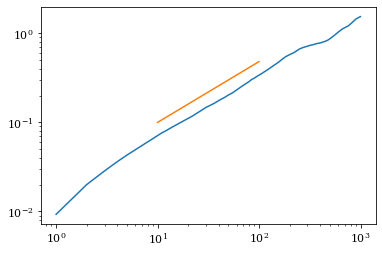

In [255]:
from src.data_import_funcs import pltpwrl
plt.plot(sfs.loc[sfs["int_index"]==1, "lag"], sfs.loc[sfs["int_index"]==1, "sf_2"])
pltpwrl(10,0.1, 10, 100, interval_metadata.loc[1, "slope"])
plt.semilogx()
plt.semilogy()

Briefly limiting to processing single interval

### 4. Duplicate, gap and interpolate intervals, and calculate SFs and slopes

In [242]:
index_list = []
version_list = []
handling_list = []
missing_list = []
slopes_list = []

outputs = pd.DataFrame()
inputs = pd.DataFrame()

for index in range(len(good_inputs_list)):
    input = good_inputs_list[index]

    for j in range(times_to_gap):
        total_removal = np.random.uniform(0, 0.95)
        ratio_removal = np.random.uniform(minimum_missing_chunks, 1)
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )
        if prop_removed >= 0.95 or prop_removed == 0:
            # print(">95% or 0% data removed, skipping")
            continue

        bad_output, slope = sf.compute_sf(pd.DataFrame(bad_input), lags, powers, False, False, [10,100])
        bad_output["int_index"] = index
        bad_output["version"] = j
        bad_output["handling"] = "none"
        outputs = pd.concat([outputs, bad_output])

        for handling in ["none", "lint"]:
            index_list.append(index)
            version_list.append(j)
            missing_list.append(prop_removed*100)
            handling_list.append(handling)

            if handling == "none":
                slopes_list.append(slope)
                bad_input_df = pd.DataFrame(bad_input)
                bad_input_df["handling"] = handling
                    # Once we are done with computing the SF, add some metadata to the interval
                bad_input_df["int_index"] = index
                bad_input_df["version"] = j
                inputs = pd.concat([inputs, bad_input_df])

            elif handling == "lint":
                interp_input = bad_input.interpolate(method="linear")
                interp_output, slope = sf.compute_sf(pd.DataFrame(interp_input), lags, powers, False, False, [10,100])
                slopes_list.append(slope)
                
                # # Once we are done with computing the SF, add some metadata to the interval
                interp_input_df = pd.DataFrame(interp_input)
                interp_input_df["int_index"] = index
                interp_input_df["version"] = j
                interp_input_df["handling"] = handling
                inputs = pd.concat([inputs, interp_input_df])

                interp_output["int_index"] = index
                interp_output["version"] = j
                interp_output["handling"] = handling
                outputs = pd.concat([outputs, interp_output])

In [244]:
ints_copies_meta = pd.DataFrame({"int_index": index_list, "version": version_list, "missing_percent_overall": missing_list, "gap_handling": handling_list, "slope": slopes_list})
ints_copies_meta

,int_index,version,missing_percent_overall,gap_handling,slope
0,0,0,39.49,none,0.596547
1,0,0,39.49,lint,0.649390
2,0,1,75.71,none,0.664977
3,0,1,75.71,lint,0.645371
4,1,0,50.46,none,0.680963
5,1,0,50.46,lint,0.672158
6,1,1,64.34,none,0.809280
7,1,1,64.34,lint,0.829911


Plot all bad and interpolated intervals, with true in background

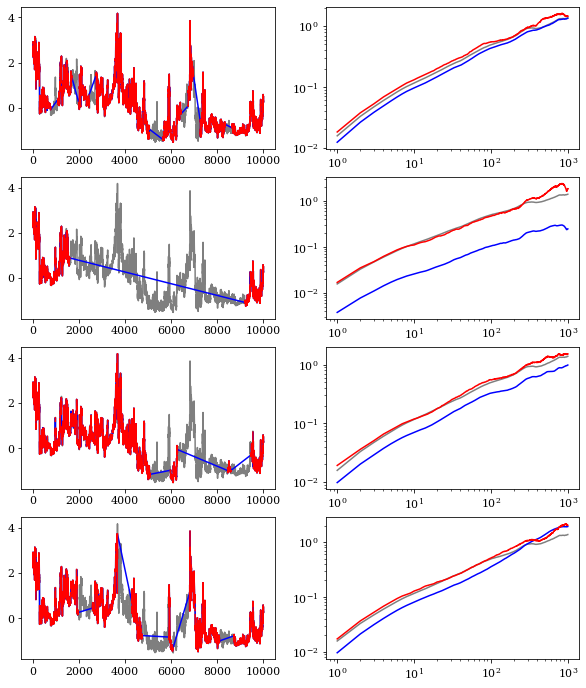

In [245]:
# # Quick check of results
n_versions = 4
fig, ax = plt.subplots(n_versions, 2, figsize=(10, n_versions*3))
for i in range(n_versions):
    ax[i, 0].plot(good_inputs_list[0].values, alpha=0.5, c="black")
    ax[i, 0].plot(all_interp_inputs_list[0][i], c="blue")
    ax[i, 0].plot(all_bad_inputs_list[0][i], c="red")
    ax[i, 1].plot(good_outputs_list[0]["sf_2"], alpha=0.5, c="black")
    ax[i, 1].plot(all_interp_outputs_list[0][i]["sf_2"], c="blue")
    ax[i, 1].plot(all_bad_outputs_list[0][i]["sf_2"], c="red")
    ax[i, 1].semilogx()
    ax[i, 1].semilogy()
#plt.savefig("data/processed/validation_plot.png")
#print("Validation plot saved")


### 5. Calculate errors relative to true values

Simply join dataframes and do column operation

In [247]:
good_outputs_list

[         lag     n    sf_0.5  missing_percent  sf_0.5_std_err      mapd  \
 1.0      1.0  9999  0.239586              0.0        0.001398  0.045500   
 2.0      2.0  9998  0.285889              0.0        0.001679  0.065841   
 3.0      3.0  9997  0.311522              0.0        0.001843  0.077117   
 4.0      4.0  9996  0.330458              0.0        0.001971  0.086289   
 5.0      5.0  9995  0.344736              0.0        0.002068  0.092585   
 ...      ...   ...       ...              ...             ...       ...   
 995.0  995.0  9005  0.838640              0.0        0.004371  0.651612   
 996.0  996.0  9004  0.838790              0.0        0.004370  0.651270   
 997.0  997.0  9003  0.837956              0.0        0.004384  0.651747   
 998.0  998.0  9002  0.838443              0.0        0.004379  0.653054   
 999.0  999.0  9001  0.839200              0.0        0.004371  0.652491   
 
                                                diffs_0.5  diffs_0.5_std  \
 1.0    [0

In [246]:
outputs

,lag,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se,int_index,version,handling
1.0,1.0,5541,44.584458,0.241860,0.001878,0.015759,0.000766,0,0,none
2.0,2.0,5536,44.628926,0.285579,0.002226,0.031738,0.001733,0,0,none
3.0,3.0,5544,44.543363,0.309154,0.002421,0.044303,0.002497,0,0,none
4.0,4.0,5533,44.647859,0.327100,0.002562,0.054984,0.003012,0,0,none
5.0,5.0,5538,44.592296,0.339843,0.002679,0.064442,0.003340,0,0,none
...,...,...,...,...,...,...,...,...,...,...
995.0,995.0,9005,0.000000,0.830496,0.003771,1.089046,0.016651,1,1,lint
996.0,996.0,9004,0.000000,0.830783,0.003771,1.089973,0.016654,1,1,lint
997.0,997.0,9003,0.000000,0.831118,0.003771,1.090971,0.016656,1,1,lint
998.0,998.0,9002,0.000000,0.831397,0.003772,1.092007,0.016658,1,1,lint


### 6. For PSP training set, create 2D and 3D heatmaps and export

### 7. For PSP and Wind test sets, apply the correction factor and calculate slopes

### 8. Again calculate errors relative to true values